Ej. 4) Idem al problema anterior pero ahora que la función de costo sea Categorical Cross-Entropy.\
Esta función de costo puede verse, al igual que para el clasificador lineal SoftMax, como\
aplicar la función softmax seguido de la log-likelihood. Modificar el código anterior para\
que se pueda cambiar la métrica a utilizar (loss_mse o loss_softmax) y lo mismo para el\
cálculo del gradiente (grad_mse o grad_softmax). Analizar los resultados respecto a los\
clasificadores lineales SVM y Softamx como también con la resolución del punto anterior.\
Armar un gráfico aparte para mostrar la precisión de estos cuatro métodos todos juntos\
(sólo para los datos de testing)

Ej. 5) Idem al problema anterior pero esta vez que las funciones de activación de la capa oculta\
sean ReLU y las de la capa de salida sean sigmoidal. Al igual que en los problemas anteriores\
armar el grafo, calcular los gradientes, graficar la evolución de la precisión (accuracy) y las\
funciones de costo (mse y categorical cross-entropy) para las distintas épocas tanto para los\
datos de validación como entrenamiento. Discuta que métrica es mejor y porque. Además\
analizar qué pasa si usamos una ReLU + activación lineal en la última capa. Explicar y\
fundamentar si usar una activación lineal en la última capa es mejor o no.

In [2]:
import numpy as np
from scipy import linalg
from scipy.special import expit
from matplotlib import pyplot as plt
from keras.datasets import cifar10

In [1]:
names_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 
              3: 'cat', 4: 'deer', 5: 'dog', 
              6: 'frog', 7: 'horse', 8: 'ship', 
              9: 'truck'}

In [3]:
def clean(X):
        X_norm = X.reshape(len(X), X[0].size).astype(float)
        X_norm -= np.mean(X)
        X_norm /= np.std(X).astype(float)
        return X_norm

In [4]:
def sigmoid(z):
    return expit(z)

def sigprime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [5]:
def accuracy(ypred, ytrue):
    ypred_idx = np.argmax(ypred, axis=1)

    return np.mean(ypred_idx==ytrue)

In [6]:
def MSE(yb_pred, yb):
    diff = np.copy(yb_pred)
    m = yb_pred.shape[0]
    idx = np.arange(0, m)
    diff[idx, yb] -= 1

    return (linalg.norm(diff)**2 / (2*m))

def grad_MSE(yb_pred, yb):
    diff = np.copy(yb_pred)
    m = yb_pred.shape[0]
    idx = np.arange(0, m)
    diff[idx, yb] -= 1
    
    return diff/m

![backprop](backprop.png)

In [12]:
def fit(Xtrain, ytrain, Xtest, ytest, batch_size, metric='MSE', epochs=10, alpha=.001, lambda_= .001):
    #Calculo tamaño del batch
    #Inicializo variables etc
    m = Xtrain.shape[0]
    n = Xtrain.shape[1]
    n_batches = int(m/batch_size)
    grad_metric = "grad_"+metric

    Xtrain = np.hstack((np.ones((m, 1)), Xtrain))
    Xtest = np.hstack((np.ones((Xtest.shape[0], 1)), Xtest))

    Xb = np.zeros((batch_size, n), dtype=float)
    Xb = np.hstack((np.ones((batch_size, 1)), Xb))
    yb = np.zeros((batch_size), dtype=float)
    W1 = np.random.uniform(-1e-2, 1e-2, size=(n+1, 100))
    W2 = np.random.uniform(-1e-2, 1e-2, size=(101, 10))

    loss_train = []
    acc_train = []
    loss_test = []
    acc_test = []

    for epoch in range(epochs):
        #Shuffle indice datos de training
        shuffle = np.random.permutation(m)

        Xtrain = Xtrain[shuffle]
        ytrain = ytrain[shuffle]
        loss=0
        #Calculo terminos de regularizacion
        L2 = linalg.norm(W1)**2 + linalg.norm(W2)**2

        for batch in range(n_batches):
            Xb = Xtrain[batch*batch_size : (batch+1)*batch_size, :]
            yb = ytrain[batch*batch_size : (batch+1)*batch_size]
            
            #Forward todo mi batch
            z1 = sigmoid(np.dot(Xb, W1))
            z1 = np.hstack((np.ones((batch_size, 1)), z1))
            yb_pred = np.dot(z1, W2)

            #Calculo loss con la metrica elegida
            loss += globals()[metric](yb_pred, yb) + (lambda_/2) * L2

            #Calculo grads:
            #grad de la funcion de loss
            grad = globals()[grad_metric](yb_pred, yb)

            #Layer 2
            gradW2 = np.dot(z1.T, grad) #S1 tiene la columna de unos
            grad = np.dot(grad, W2.T)
            grad = grad[:, 1:]  

            #Layer 1
            grad_sig = sigprime(np.dot(Xb, W1))
            grad = grad * grad_sig  #Producto elemento a elemento
            gradW1 = np.dot(Xb.T, grad) #Xb incluye columna de 1s
            
            W1 -= alpha*(gradW1 + lambda_ * W1)
            W2 -= alpha*(gradW2 + lambda_ * W2)
        
        #Calculo loss y accuracy
        loss_train.append(loss/n_batches)
        acc_train.append(accuracy(yb_pred, yb))
        
        z1t = sigmoid(np.dot(Xtest, W1))
        z1t = np.hstack((np.ones((Xtest.shape[0], 1)), z1t))
        ybt_pred = np.dot(z1t, W2)
        loss_test.append(globals()[metric](ybt_pred, ytest) + (lambda_/2) * L2)
        acc_test.append(accuracy(ybt_pred, ytest))
        
        if epoch%10 == 0:
            print("Train loss of epoch {}: {:.6f}, Train accuracy: {:.2f}%".format(epoch, loss_train[-1], 100*acc_train[-1]))
    return loss_train, loss_test, acc_train, acc_test




In [13]:
(Xtrain, ytrain), (Xtest, ytest) = cifar10.load_data()

ytrain = ytrain[:,0]
ytest = ytest[:,0]

Xtrain = clean(Xtrain)
Xtest = clean(Xtest)
# summarize loaded dataset
print('Train: X=%s, y=%s' % (Xtrain.shape, ytrain.shape))
print('Test: X=%s, y=%s' % (Xtest.shape, ytest.shape))

Train: X=(50000, 3072), y=(50000,)
Test: X=(10000, 3072), y=(10000,)


In [14]:
(loss_train, loss_test, acc_train, acc_test) = fit(Xtrain, ytrain, Xtest, ytest, batch_size=50, metric="MSE", epochs=300, alpha=1e-4, lambda_=.01)

Train loss of epoch 0: 0.513325, Train accuracy: 18.00%
Train loss of epoch 10: 0.492046, Train accuracy: 24.00%
Train loss of epoch 20: 0.483307, Train accuracy: 28.00%
Train loss of epoch 30: 0.477000, Train accuracy: 34.00%
Train loss of epoch 40: 0.472184, Train accuracy: 22.00%
Train loss of epoch 50: 0.468410, Train accuracy: 24.00%
Train loss of epoch 60: 0.465370, Train accuracy: 40.00%
Train loss of epoch 70: 0.462810, Train accuracy: 38.00%
Train loss of epoch 80: 0.460548, Train accuracy: 24.00%
Train loss of epoch 90: 0.458501, Train accuracy: 28.00%
Train loss of epoch 100: 0.456621, Train accuracy: 34.00%
Train loss of epoch 110: 0.454877, Train accuracy: 30.00%
Train loss of epoch 120: 0.453254, Train accuracy: 28.00%
Train loss of epoch 130: 0.451723, Train accuracy: 28.00%
Train loss of epoch 140: 0.450271, Train accuracy: 34.00%
Train loss of epoch 150: 0.448881, Train accuracy: 32.00%
Train loss of epoch 160: 0.447547, Train accuracy: 46.00%
Train loss of epoch 170: 

0.3751

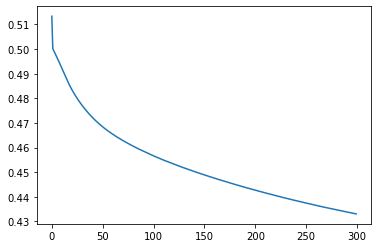

In [16]:
plt.plot(loss_train);
#plt.plot(loss_test)
acc_test[-1]